In [1]:
# help function
from transfer_learning import NeuralNet_sherpa_optimize
from Functions import data_loader, get_descriptors, one_filter, data_scaler

# modules
import torch
import torch.nn as nn
import torch.optim as optim

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

# New
from transfer_learning import MyDataset
from Functions import stratified_cluster_sample
from ignite.engine import Engine, Events, create_supervised_evaluator
from ignite.metrics import Loss
from ignite.contrib.metrics.regression import R2Score
import time
from ignite.engine import Events, create_supervised_evaluator
from sklearn.metrics import r2_score


# file name and data path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_path = os.getcwd()
file_name = "data/CrystGrowthDesign_SI.csv"

"""
Data description.

    Descriptors:
        'void fraction', 'Vol. S.A.', 'Grav. S.A.', 'Pore diameter Limiting', 'Pore diameter Largest'
    Source task:
        'H2@100 bar/243K (wt%)'
    Target tasks:
        'H2@100 bar/130K (wt%)' 'CH4@100 bar/298 K (mg/g)' '5 bar Xe mol/kg' '5 bar Kr mol/kg'
"""

descriptor_columns = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
one_filter_columns = ["H2@100 bar/243K (wt%)"]
another_filter_columns = ['H2@100 bar/130K (wt%)']

# load data
data = data_loader(base_path, file_name)
data = data.reset_index(drop=True)
epochs = 10000
batch_size = 128
# parameters
input_size = 5
output_size = 1

# file specifics 
#filename = f"data_epochs-{epochs}_bs-{batch_size}"
trial_parameters={
    "lr" : 0.003703,
    "H_l1" :327 ,
    "activate" :  "nn.PReLU"
}
#format data
learning_rate = trial_parameters["lr"]
df, t_1, t_2, y_1, y_2 = stratified_cluster_sample(
    1, data, descriptor_columns, one_filter_columns[0], 5, net_out=True
)
df = df[0]
df=df.drop("Cluster",axis=1)
interest = one_filter_columns[0]
#descriptor_columns.append("Cluster")
features = descriptor_columns

df_train, df_val, y_df_train, y_df_val = train_test_split(
    df[features], df[interest], test_size=0.1
)
df_train[interest] = np.array(y_df_train)
df_val[interest] = np.array(y_df_val)
first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)
second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

train_loss = []
train_r_2 = []
val_loss = []
val_r_2 = []
test_loss = []
test_r_2 = []
net_time = []
#create model
model = NeuralNet_sherpa_optimize(5, 1, trial_parameters).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train_step(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()

trainer = Engine(train_step)


metrics = {"loss": Loss(criterion), "r_2": R2Score()}

#train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
# train_evaluator.logger = setup_logger("Train Evaluator")
#validation_evaluator = create_supervised_evaluator(
#    model, metrics=metrics, device=device
#)
# validation_evaluator.logger = setup_logger("Val Evaluator")




train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size,shuffle=True)
start = time.time()
trainer.logger.disabled=True
trainer.run(train_loader, max_epochs=epochs)


descriptor_columns = [
    "void fraction",
    "Vol. S.A.",
    "Grav. S.A.",
    "Pore diameter Limiting",
    "Pore diameter Largest",
]
model.fc1.weight.requires_grad = False
model.fc1.bias.requires_grad = False
model.fc2.weight.requires_grad = False
model.fc2.bias.requires_grad = False
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate
)
df, t_1, t_2, y_1, y_2 = stratified_cluster_sample(
    1, data, descriptor_columns, another_filter_columns[0], 5, net_out=True
)
df = df[0]
df=df.drop("Cluster",axis=1)
interest = another_filter_columns[0]
#descriptor_columns.append("Cluster")
features = descriptor_columns

df_train, df_test, y_df_train, y_df_test = train_test_split(
    df[features], df[interest], test_size=0.2
)
y_df_train=y_df_train.reset_index(drop=False)
df_train, df_val, y_df_train, y_df_val = train_test_split(
    df_train[features], y_df_train[interest], test_size=0.2
)
df_train[interest] = np.array(y_df_train)
df_val[interest] = np.array(y_df_val)
df_test[interest]=np.array(y_df_test)
interest=another_filter_columns[0]
first = MyDataset(df_train, interest, features)
train_loader = torch.utils.data.DataLoader(first, batch_size=batch_size)

second = MyDataset(df_val, interest, features)
val_loader = torch.utils.data.DataLoader(second, batch_size=len(df_val))

third = MyDataset(df_test, interest, features)
test_loader=torch.utils.data.DataLoader(third, batch_size=len(df_test))

def train_step_1(engine, batch):
    x, y = batch
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    return loss.item()
transfer_trainer = Engine(train_step_1)
metrics = {"loss": Loss(criterion), "r_2": R2Score()}
@transfer_trainer.on(Events.EPOCH_COMPLETED(every=50))
def store_metrics(engine):
    end = time.time()
    e = engine.state.epoch
    out=float(criterion(model(train_loader.dataset.x_train),train_loader.dataset.y_train))
    out1=float(r2_score(model(train_loader.dataset.x_train).detach().numpy(),train_loader.dataset.y_train.detach().numpy()))
    out2=float(criterion(model(val_loader.dataset.x_train),val_loader.dataset.y_train))
    out3=float(r2_score(model(val_loader.dataset.x_train).detach().numpy(),val_loader.dataset.y_train.detach().numpy()))
    out4=float(criterion(model(test_loader.dataset.x_train),test_loader.dataset.y_train))
    out5=float(r2_score(model(test_loader.dataset.x_train).detach().numpy(),test_loader.dataset.y_train.detach().numpy()))
    train_loss.append(out)
    train_r_2.append(out1)
    val_loss.append(out2)
    val_r_2.append(out3)
    test_loss.append(out4)
    test_r_2.append(out5)
    net_time.append(end-start)
    print(e)
transfer_trainer.logger.disabled=True
transfer_trainer.run(train_loader, max_epochs=epochs)

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000
8050
8100
8150
8200
8250
8300
8350
8400
8450
8500
8550
8600
8650
8700
8750
8800
8850
8900
8950
9000
9050
9100
9150
9200
9250
9300
9350
9400
9450
9500
9550
9600
9650
9700
9750
9800
9850
9900
9950
10000


State:
	iteration: 680000
	epoch: 10000
	epoch_length: 68
	max_epochs: 10000
	output: 0.04944636672735214
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

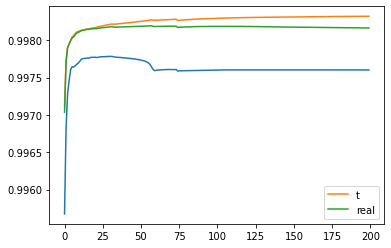

In [2]:
import matplotlib.pyplot as plt
plt.plot(val_r_2)
plt.plot(train_r_2,label="t")
plt.plot(test_r_2,label="real")
plt.legend()

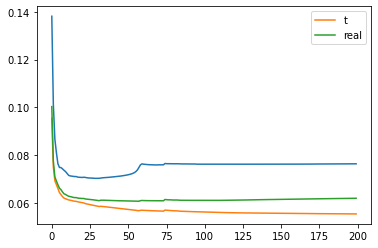

In [3]:
plt.plot(val_loss)
plt.plot(train_loss,label="t")
plt.plot(test_loss,label="real")
plt.legend()

In [4]:
torch.save(model, "XE_opts.ckpt")
